# **Reinforcement Learning Project - Inventory beer game**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

### **Setup**

In [2]:
# Supply Chain and its agents
supply_chain = {'level 0': 'Customer',
                'level 1': 'Retailer',
                'level 2': 'Distributor'
                'level 3': 'Manufacturer'}

agents = [supply_chain[i] for i in list(supply_chain.keys())[1:]]


# All possible coded inventory positions of agents and the respective state pairs (5 states with 25 state pairs)
states = np.arange(start=1, stop=6)
state_pairs = [(i, j) for i in states for j in states]

# y-value in ordering rule x+y with x equal to the demand from the downstream agent and the respective action pairs (4 actions with 16 action pairs)
actions = np.arange(stop=4)
action_pairs = [(i, j) for i in actions for j in actions]


# Initial matrix with Q-values (minimization -> high values)
Q_values = np.full(shape=(len(state_pairs), len(action_pairs)), fill_value=10000)
df_Q_values = pd.DataFrame(data=Q_values, index=state_pairs, columns=action_pairs)
display(df_Q_values.head())

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
"(1, 1)",10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
"(1, 2)",10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
"(1, 3)",10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
"(1, 4)",10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
"(1, 5)",10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


In [3]:
# Define parameters
iteration = 1
max_iteration = 50000
T = 5 #smaller
gamma = 0.8 #smaller
alpha = 0.35
sigma = 0.0001
proba_exploitation = 0.02
start_exploitation = proba_exploitation

# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]
G = [0 for i in range(T)]
q = [0 for i in range(T)]
Q = [0 for i in range(max_iteration)]

**Meaning of the variables**
- S: (start-)inventory positions/states per agent and time step t
- CS: coded states per agent and time step t
- O: ordering size per agent and time step t
- D: distribution amount per agent and time step t
- x: demand from downstream level per agent and time step t
- y: action per agent and time step t
- r: reward per agent and time step t
- R: reward of the supply chain per time step t
- Return G: total discounted rewards per time step t
- q: measure the decrease of the Q-value per time step t
- Q: measure the mean decrease of Q-values per episode to indicate convergence

In [4]:
# helperfunctions
# function to convert real states to coded states
def coded_state(inventory):
    if inventory < -5:
        return 1
    elif inventory < 0:
        return 2
    elif inventory < 5:
        return 3
    elif inventory < 12:
        return 4
    else:
        return 5


# function to view episodes
def fun_episode(S, CS, D, O, x, y, r, head=True):
    time_steps = ['t='+str(i) for i in np.arange(start=1, stop=T+2)]

    df = pd.DataFrame({'Inventory/States S': [tuple(i) for i in S],
                   'Coded states CS': [tuple(i) for i in CS],
                   'Demand x': [tuple(i) for i in x],
                   'Distribution amount D': [tuple(i) for i in D],
                   'Action y': [tuple(i) for i in y],
                   'Ordering size': [tuple(i) for i in O],
                   'Costs r': [tuple(i) for i in r]},
                   index=time_steps)
    df.index.name = 'Time'
    if head == True:
        return display(df.head())
    else: return display(df)


# function to define the starting states of the supply chain
def fun_start_state(how='value', inv=12):
    # select own start values for all agents
    if how == 'value':
        for agent in range(len(agents)):
            S[0][agent] = inv
            CS[0][agent] = coded_state(S[0][agent])
    
    # each episode has a change of 50% to start with high (12) or with low (-2) inventory for all agents
    elif how == 'high/low':
        starting_state = random.choices(population=['high', 'low'], weights=[0.5, 0.5])[0]
        if starting_state == 'high':
            for agent in range(len(agents)):
                S[0][agent] = 12
                CS[0][agent] = coded_state(S[0][agent])
        else:
            for agent in range(len(agents)):
                S[0][agent] = 0
                CS[0][agent] = coded_state(S[0][agent])

    # random starting positions (-10 to 16) of agents for each episode
    elif how == 'random':
        for agent in range(len(agents)):
            S[0][agent] = random.choices(np.arange(start=-10, stop=16))[0]
            CS[0][agent] = coded_state(S[0][agent])


# function to measure the Q-value decrease
def fun_q_decrease(alpha, q_value, G):
    new_q_value = (1-alpha) * q_value + alpha * G
    decrease = (q_value - new_q_value) / q_value
    return new_q_value, decrease


# function to visualize the Q-vlaue decrease
def plot_q_decrease(Q, iteration):
    plt.figure(figsize=(12,4))
    plt.plot(Q)
    plt.xlim(0, iteration)
    plt.ylim(0, 1.1)
    plt.xlabel('episode/iteration')
    plt.ylabel('Q-value decrease')
    plt.title('Q-value decrease per episode', size=18)
    return plt.show()

In [5]:
# Three possible options to set starting states
fun_start_state(how='value', inv=10)
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

fun_start_state(how='high/low')
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

fun_start_state(how='random')
print('Inventory state S: {}'.format(S))
print('Coded state S: {}\n'.format(CS))

Inventory state S: [[10, 10], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
Coded state S: [[4, 4], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]

Inventory state S: [[12, 12], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
Coded state S: [[5, 5], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]

Inventory state S: [[2, -3], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
Coded state S: [[3, 2], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]



iteration 1


C:\Users\Dennis\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Dennis\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


iteration 10
iteration 100
iteration 1000
iteration 10000
iteration 25000
iteration 50000


,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
"(1, 1)",64.20,95.57,109.47,93.43,144.78,113.52,105.89,125.84,105.73,93.37,111.61,106.73,92.88,136.57,96.71,93.90
"(1, 2)",133.59,133.92,117.48,114.51,137.83,144.73,130.46,134.57,113.36,136.56,118.69,125.50,168.94,114.19,65.85,121.58
"(1, 3)",163.17,126.15,84.07,129.63,135.82,131.43,120.83,123.40,129.67,126.15,139.71,122.84,131.38,136.19,146.87,130.94
"(1, 4)",119.33,104.38,114.57,73.60,106.50,123.60,72.78,119.94,131.81,116.24,124.81,113.95,119.89,114.90,115.90,113.99
"(1, 5)",139.71,154.62,126.79,136.84,138.72,142.64,126.94,124.66,74.18,122.77,114.73,119.60,127.82,132.64,123.26,121.79
"(2, 1)",139.50,111.98,103.70,96.57,100.93,112.23,88.63,102.41,107.06,36.50,103.72,64.91,110.25,96.91,116.96,92.79
"(2, 2)",77.05,104.56,90.68,48.74,97.90,102.84,104.36,99.51,109.46,97.04,109.33,79.78,107.06,92.38,95.96,91.36
"(2, 3)",84.02,91.90,100.97,106.85,88.20,94.43,87.06,103.75,92.41,100.93,104.41,97.84,92.27,119.32,113.92,91.97
"(2, 4)",91.84,104.20,95.00,88.87,96.10,89.86,87.48,98.03,87.60,61.45,81.08,109.52,99.11,97.12,98.68,90.64
"(2, 5)",103.19,98.88,96.51,104.13,97.47,95.69,75.02,105.08,99.45,102.50,102.01,104.82,111.97,97.00,105.50,98.71


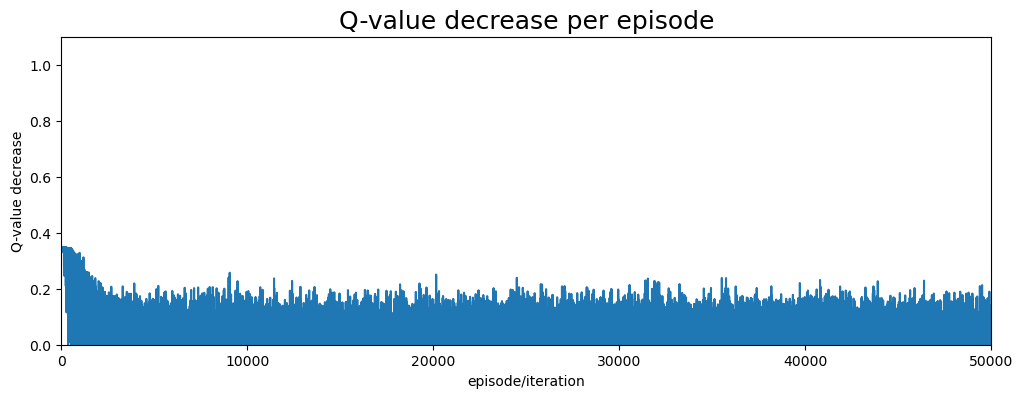

In [6]:
#%%capture
# Main function

while iteration <= max_iteration:
    if iteration in [1, 10, 100, 1000, 
                    10000, 25000, 50000, 75000, 100000, max_iteration]:
        print('iteration {}'.format(iteration))

    #print('-------------------episode {}------------------'.format(iteration))
    #print('Exploitation probability: {}\n'.format(proba_exploitation))
    t=0

    # random starting position of agents for each episode
    fun_start_state(how='random', inv=12) #option 1: ('value', inv=12); option 2: 'high/low'; option 3: 'random'

    while t < T:
        #print('-----------------time step t={}----------------'.format(t))

        # view state and coded state
        state = tuple(S[t])
        c_state = tuple(CS[t])
        #print('State S: {} and coded state CS: {}'.format(state, c_state))

        # define random lead time lag (between 0 and 2)
        lag = random.choices(population=[0, 1, 2], weights=[0.6, 0.3, 0.1])[0]
        #print('Lead time lag of {} time steps\n'.format(lag))

        for agent in range(len(agents)):
            level = supply_chain['level ' + str(agent+1)]
            #print('------------------{}------------------'.format(level))

        # step 1: receive the new demand of the downstream agent
            if level == 'Retailer':
                x[t][agent] = np.random.randint(low=0, high=15)
            else:
                x[t][agent] = O[t-1][agent-1]
            
            # Add negative inventory (=demand of previous time steps) to the new demand
            inventory = S[t][agent]
            if inventory >= 0:
                iteration
                #print('Demand x from downstream ({}) at t-1: {}'.format(supply_chain['level ' + str(agent)], x[t][agent]))
            else:
                #print('Demand x from downstream ({}) at t-1 + demand of previous time steps:'.format(supply_chain['level ' + str(agent)]))
                #print(    '{} + {} = {}'.format(x[t][agent], np.abs(inventory), x[t][agent] + np.abs(inventory)))
                x[t][agent] += np.abs(inventory)

        # step 2: fulfill order of downstream agent from onhand inventory and calculate possible backlog costs
            if inventory >= 0:
                D[t][agent] = min(x[t][agent], inventory) #distribution quantity
                #print('Distribution size D: {}'.format(D[t][agent]))
            elif level != agents[-1]:
                D[t][agent] = min(x[t][agent], D[max(0, t-1)][agent+1]) #negative inventory is demand of previous time steps and still needs to be complied
                #print('Distribution size D (delivery of upstream agent in t-1): {}'.format(D[t][agent]))
            else: D[t][agent] = min(x[t][agent], O[max(0, t-1)][agent])
            backlog = x[t][agent] - D[t][agent] #penalty/backlog costs (previous backlogs included in demand if inventory is negative)
            #print('Backlog size: {}'.format(backlog))

        # step 3: placing order for stock replenishment
            # define best action for agent and select it with initially very small probability (first exploration and mostly random choices)
            best_action = df_Q_values.iloc[df_Q_values.index.get_loc(tuple(CS[t]))].idxmin()[agent]
            #print('Best action y*: {}'.format(best_action))

            y[t][agent] = random.choices([best_action] + list(actions), weights=[proba_exploitation] + list(np.repeat((1 - proba_exploitation) / len(actions), len(actions))))[0]
            #print('Action y: {}'.format(y[t][agent]))

            if inventory >= 0:
                O[t][agent] = x[t][agent] + y[t][agent] #O[t+lag] !!
            else: O[t][agent] = x[t][agent] + inventory + y[t][agent] #subtract negative inventory (demand of previous time steps) again - has been ordered already
            #print('Ordering size O: {}\n'.format(O[t][agent]))

        # step 4: previous orders are received from the upstream agent (update states for t+1)
        #print('UPDATING STATES AND CALCULATING COSTS PER AGENT')
        for agent in range(len(agents)):
            level = supply_chain['level ' + str(agent+1)]
            #print('------------------{}------------------'.format(level))

            if  S[t][agent] >= 0:
                inventory =  S[t][agent] - x[t][agent]
            else: inventory = - x[t][agent] #demand x contains negative inventory + new demand = new inventory
            #if level == 'Retailer': lag = 0 #retailer's lead time to customer is zero
            if level != agents[-1]:
                if t == 0:
                    S[t+1][agent] = inventory + truck_load + D[t][agent+1] #truck load represets order of t-2
                    #print('Inventory {} after receiving truck load +{} (demand of t-2) and order +{}: {}'.format(inventory, truck_load, D[t][agent+1], S[t+1][agent]))
                elif t == 1:
                    S[t+1][agent] = inventory + train_load + D[t][agent+1] #train load represets order of t-1
                    #print('Inventory {} after receiving train load +{} (demand of t-1) and order +{}: {}'.format(inventory, train_load, D[t][agent+1], S[t+1][agent]))
                else:
                    S[t+1][agent] = inventory + D[t][agent+1]
                    #print('Inventory {} after receiving order +{} of t-1: {}'.format(inventory, D[t][agent+1], S[t+1][agent]))
            else:
                S[t+1][agent] = inventory + O[t-1][agent] #last agent in supply chain has no supplier (delivers from warehouse)
                #print('Inventory {} receiving order +{} of t-1: {}'.format(inventory, O[t-1][agent], S[t+1][agent]))
            
            # update coded states
            CS[t+1][agent] = coded_state(S[t+1][agent])

            # calculate agent's costs (onhand inventory holding costs + penalty costs)
            r[t][agent] = 1 * max(S[t+1][agent], 0) + 2 * (x[t][agent] - D[t][agent]) #backlog
            #print('Costs r: {}\n'.format(r[t][agent]))

        # calculate the total supply chain costs in t
        action = tuple(y[t])
        R[t] = np.sum(r[t])
        #print('Supply Chain costs R in state {} with action {} at t={}: {}'.format(state, action, t, R[t]))            
        
        # increase time step t
        t += 1
        #print('\n\n')

    # view last episode
    #fun_episode(S, CS, D, O, x, y, r, head=False)

    # Loop from T to t=0 to calculate immediate rewards and returns
    #print('-----Rewards and Total discounted returns-----')
    for t in np.arange(start=0, stop=T)[::-1]:
        # view immediate reward of each visited state-action-pair
        #print('Immediate reward R in t={}: {}'.format(t, R[t]))

        # calculate the return G: total discounted rewards
        G[t] = R[t] + np.sum(R[t+1:] * np.array([gamma**i for i in np.arange(start=1, stop=T-t)]))
    
    # view returns of all state-action-pairs
    #print('\nTotal discounted rewards (Return G): \n{}\n'.format(G))

    # update all visited Q-values
    #print('---------------UPDATING Q-VALUES--------------')
    for t in range(T):
        state = tuple(CS[t])
        action = tuple(y[t])

        # get current Q-value
        q_value = df_Q_values.iloc[df_Q_values.index.get_loc(state), df_Q_values.columns.get_loc(action)]
        #print('t={}: state: {}, action: {}, old Q-value: {}, return: {}'.format(t, state, action, q_value, G[t]))

        # update Q-values according to equation 12 in the paper (slide 30 TD-learning script)
        df_Q_values.iloc[df_Q_values.index.get_loc(state), df_Q_values.columns.get_loc(action)] = (1-alpha) * q_value + alpha * G[t] #equal to: q_value + alpha * (G[t] - q_value)
        new_q_value, decrease = fun_q_decrease(alpha, q_value, G[t])
        q[t] = decrease
        #print('New Q-value: {}\n'.format(new_q_value))

    # calculate mean Q-value decrease of current episode
    Q[iteration-1] = np.mean(q)

    # Check if the convergence criterion has been reached
    if (iteration > 100) & (np.mean(np.abs(Q[iteration-5:iteration])) < sigma):
        print('Convergence!')
        break

    # increase exploitation probability linearly
    proba_exploitation += (0.95 - start_exploitation) / max_iteration
    #print('\n\n')

    # start with next iteration
    iteration += 1

# round dataframe with Q-values
df_Q_values = np.round(df_Q_values, 2)

# view new Q-value table
display(df_Q_values)

# plot decrease of Q-vlaues
plot_q_decrease(Q, iteration)

### **View new Q-values**

In [7]:
np.sum([i != 0 for i in Q])

#np.mean(q)

50000

Number of state-action-pairs: 400
Percentage of updated Q-values: 100 %

Number of visits with max_iteration=50000 and T=5: 250000
Average amount of visits per state-action-pair: 625.0

Last five Q-value decreases: [ 0.0046 -0.061   0.0861 -0.0701  0.0111]
Mean of last five Q-value decreases: -0.0059


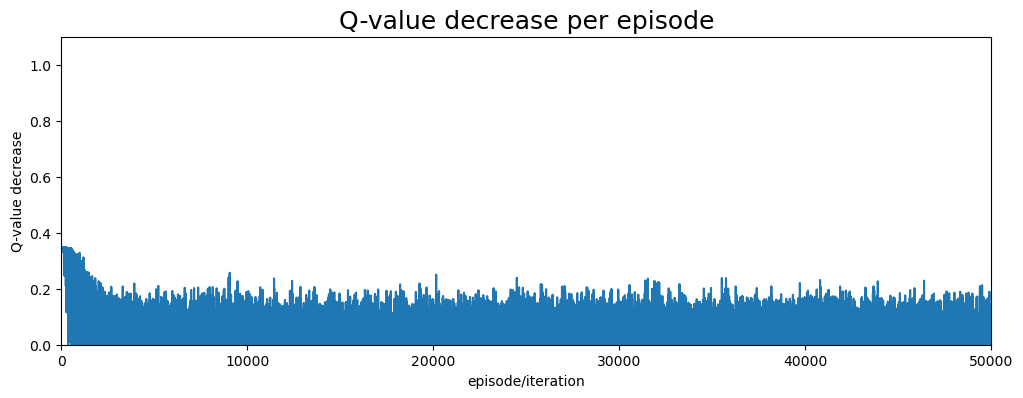

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(2, 0)","(2, 1)","(2, 2)","(2, 3)","(3, 0)","(3, 1)","(3, 2)","(3, 3)"
"(1, 1)",64.20,95.57,109.47,93.43,144.78,113.52,105.89,125.84,105.73,93.37,111.61,106.73,92.88,136.57,96.71,93.90
"(1, 2)",133.59,133.92,117.48,114.51,137.83,144.73,130.46,134.57,113.36,136.56,118.69,125.50,168.94,114.19,65.85,121.58
"(1, 3)",163.17,126.15,84.07,129.63,135.82,131.43,120.83,123.40,129.67,126.15,139.71,122.84,131.38,136.19,146.87,130.94
"(1, 4)",119.33,104.38,114.57,73.60,106.50,123.60,72.78,119.94,131.81,116.24,124.81,113.95,119.89,114.90,115.90,113.99
"(1, 5)",139.71,154.62,126.79,136.84,138.72,142.64,126.94,124.66,74.18,122.77,114.73,119.60,127.82,132.64,123.26,121.79
"(2, 1)",139.50,111.98,103.70,96.57,100.93,112.23,88.63,102.41,107.06,36.50,103.72,64.91,110.25,96.91,116.96,92.79
"(2, 2)",77.05,104.56,90.68,48.74,97.90,102.84,104.36,99.51,109.46,97.04,109.33,79.78,107.06,92.38,95.96,91.36
"(2, 3)",84.02,91.90,100.97,106.85,88.20,94.43,87.06,103.75,92.41,100.93,104.41,97.84,92.27,119.32,113.92,91.97
"(2, 4)",91.84,104.20,95.00,88.87,96.10,89.86,87.48,98.03,87.60,61.45,81.08,109.52,99.11,97.12,98.68,90.64
"(2, 5)",103.19,98.88,96.51,104.13,97.47,95.69,75.02,105.08,99.45,102.50,102.01,104.82,111.97,97.00,105.50,98.71


In [8]:
# Percentage of updated Q-values
num_pairs = len(df_Q_values.index) * len(df_Q_values.columns)
print('Number of state-action-pairs: {}'.format(num_pairs))
print('Percentage of updated Q-values: {} %\n'.format(int(np.sum(np.sum(df_Q_values != 1000)) / num_pairs * 100)))

visits = max_iteration * T
print('Number of visits with max_iteration={} and T={}: {}'.format(max_iteration, T, visits))
print('Average amount of visits per state-action-pair: {}\n'.format(visits / num_pairs))

# plot decrease of Q-vlaues
iteration = max_iteration
print('Last five Q-value decreases: {}'.format(np.round(Q[iteration-5:iteration], 4)))
print('Mean of last five Q-value decreases: {}'.format(np.round(np.mean(Q[iteration-5:iteration]), 4)))

plot_q_decrease(Q, iteration)

df_Q_values

### **Test performance of the Reinforcement learning ordering mechanism (RLOM) on main and test problems**

In [9]:
# Main test problem
customer_demand = [15,10,8,14,9,3,13,2,13,11,3,4,6,11,15,12,15,4,12,3,13,10,15,15,3,11,1,13,10,10,0,0,8,0,14]
lead_times = [2,0,2,4,4,4,0,2,4,1,1,0,0,1,1,0,1,1,2,1,1,1,4,2,2,1,4,3,4,1,4,0,3,3,4]

# # Test problem 1
# customer_demand = [5,14,14,13,2,9,5,9,14,14,12,7,5,1,13,3,12,4,0,15,11,10,6,0,6,6,5,11,8,4,4,12,13,8,12]
# lead_times = [2,0,2,4,4,4,0,2,4,1,1,0,0,1,1,0,1,1,2,1,1,1,4,2,2,1,4,3,4,1,4,0,3,3,4]

# # Test problem 2
# customer_demand = [15,10,8,14,9,3,13,2,13,11,3,4,6,11,15,12,15,4,12,3,13,10,15,15,3,11,1,13,10,10,0,0,8,0,14]
# lead_times = [4,2,2,0,2,2,1,1,3,0,0,3,3,3,4,1,1,1,3,0,4,2,3,4,1,3,3,3,0,3,4,3,3,0,3]

# # Test problem 3
# customer_demand = [13,13,12,10,14,13,13,10,2,12,11,9,11,3,7,6,12,12,3,10,3,9,4,15,12,7,15,5,1,15,11,9,14,0,4]
# lead_times = [4,2,2,0,2,2,1,1,3,0,0,3,3,3,4,1,1,1,3,0,4,2,3,4,1,3,3,3,0,3,4,3,3,0,3]

# # Own test problem
# customer_demand = list(np.random.randint(low=0, high=15, size=35))
# lead_times = list(np.random.randint(low=0, high=4, size=35))

In [10]:
# Define parameters
T = 35
truck_load = 4
train_load = 4

# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]

# Extract optimal policy of Q-values
policy = df_Q_values.idxmin(axis=1)

In [11]:
#%%capture
# Main function
t=0

# set starting position of agents
fun_start_state(how='value', inv=10)

while t < T:
    print('-----------------time step t={}----------------'.format(t))

    # view state and coded state
    state = tuple(S[t])
    c_state = tuple(CS[t])
    print('State S: {} and coded state CS: {}'.format(state, c_state))

    # define random lead time lag (between 0 and 2)
    lag = random.choices(population=[0, 1, 2], weights=[0.6, 0.3, 0.1])[0]
    print('Lead time lag of {} time steps\n'.format(lag))

    for agent in range(len(agents)):
        level = supply_chain['level ' + str(agent+1)]
        print('------------------{}------------------'.format(level))

    # step 1: receive the new demand of the downstream agent
        if level == 'Retailer':
            x[t][agent] = customer_demand[t]
        else:
            x[t][agent] = O[t-1][agent-1]
        
        # Add negative inventory (=demand of previous time steps) to the new demand
        inventory = S[t][agent]
        if inventory >= 0:
            iteration
            print('Demand x from downstream ({}) at t-1: {}'.format(supply_chain['level ' + str(agent)], x[t][agent]))
        else:
            print('Demand x from downstream ({}) at t-1 + demand of previous time steps:'.format(supply_chain['level ' + str(agent)]))
            print(    '{} + {} = {}'.format(x[t][agent], np.abs(inventory), x[t][agent] + np.abs(inventory)))
            x[t][agent] += np.abs(inventory)

    # step 2: fulfill order of downstream agent from onhand inventory and calculate possible backlog costs
        if (inventory >= 0) & (level != agents[-1]):
            D[t][agent] = min(x[t][agent], max(inventory, D[t-1][agent+1])) #distribution quantity
            print('Distribution size D: {}'.format(D[t][agent]))
        elif level != agents[-1]:
            D[t][agent] = min(x[t][agent], D[t-1][agent+1]) #negative inventory is demand of previous time steps and still needs to be complied
            print('Distribution size D (delivery of upstream agent in t-1): {}'.format(D[t][agent]))
        elif (inventory >= 0) & (level == agents[-1]):
            D[t][agent] = min(x[t][agent], max(inventory, O[t-1][agent]))
            print('Distribution size D: {}'.format(D[t][agent]))
        else:
            D[t][agent] = min(x[t][agent], O[t-1][agent])
            print('Distribution size D (delivery of warehouse): {}'.format(D[t][agent]))

    # step 3: placing order for stock replenishment (take action of optiamal policy)
        print(CS[t])
        print(CS[t][agent])
        y[t][agent] = policy[tuple(CS[t])][agent]
        print('Action y: {}'.format(y[t][agent]))

        if inventory >= 0:
            O[t][agent] = x[t][agent] + y[t][agent] #O[t+lag] !!
        else: O[t][agent] = x[t][agent] + inventory + y[t][agent] #subtract negative inventory (demand of previous time steps) again - has been ordered already
        print('Ordering size O: {}\n'.format(O[t][agent]))

    # step 4: previous orders are received from the upstream agent (update states for t+1)
    print('UPDATING STATES AND CALCULATING COSTS PER AGENT')
    for agent in range(len(agents)):
        level = supply_chain['level ' + str(agent+1)]
        print('------------------{}------------------'.format(level))

        if  S[t][agent] >= 0:
            inventory =  S[t][agent] - x[t][agent]
        else: inventory = - x[t][agent] #demand x contains negative inventory + new demand = new inventory
        #if level == 'Retailer': lag = 0 #retailer's lead time to customer is zero
        if level != agents[-1]:
            if t == 0:
                S[t+1][agent] = inventory + truck_load + D[t][agent+1] #truck load represets order of t-2
                print('Inventory {} after receiving truck load +{} (demand of t-2) and order +{}: {}'.format(inventory, truck_load, D[t][agent+1], S[t+1][agent]))
            elif t == 1:
                S[t+1][agent] = inventory + train_load + D[t][agent+1] #train load represets order of t-1
                print('Inventory {} after receiving train load +{} (demand of t-1) and order +{}: {}'.format(inventory, train_load, D[t][agent+1], S[t+1][agent]))
            else:
                S[t+1][agent] = inventory + D[t][agent+1]
                print('Inventory {} after receiving order +{} of t-1: {}'.format(inventory, D[t][agent+1], S[t+1][agent]))
        else:
            S[t+1][agent] = inventory + O[t-1][agent] #last agent in supply chain has no supplier (delivers from warehouse)
            print('Inventory {} receiving order +{} of t-1: {}'.format(inventory, O[t-1][agent], S[t+1][agent]))
        
        # update coded states
        CS[t+1][agent] = coded_state(S[t+1][agent])

        # calculate agent's costs (onhand inventory holding costs + penalty costs)
        r[t][agent] = 1 * max(S[t+1][agent], 0) + 2 * (x[t][agent] - D[t][agent]) #backlog
        print('Costs r: {}\n'.format(r[t][agent]))

    # calculate the total supply chain costs in t
    action = tuple(y[t])
    R[t] = np.sum(r[t])
    print('Supply Chain costs R in state {} with action {} at t={}: {}'.format(state, action, t, R[t]))            
    
    # increase time step t
    t += 1
    print('\n\n')

# view episode
fun_episode(S, CS, D, O, x, y, r, head=False)

-----------------time step t=0----------------
State S: (10, 10) and coded state CS: (4, 4)
Lead time lag of 0 time steps

------------------Retailer------------------
Demand x from downstream (Customer) at t-1: 15
Distribution size D: 10
[4, 4]
4
Action y: 0
Ordering size O: 15

------------------Distributor------------------
Demand x from downstream (Retailer) at t-1: 0
Distribution size D: 0
[4, 4]
4
Action y: 0
Ordering size O: 0

UPDATING STATES AND CALCULATING COSTS PER AGENT
------------------Retailer------------------
Inventory -5 after receiving truck load +4 (demand of t-2) and order +0: -1
Costs r: 10

------------------Distributor------------------
Inventory 10 receiving order +0 of t-1: 10
Costs r: 10

Supply Chain costs R in state (10, 10) with action (0, 0) at t=0: 20



-----------------time step t=1----------------
State S: (-1, 10) and coded state CS: (2, 4)
Lead time lag of 0 time steps

------------------Retailer------------------
Demand x from downstream (Customer)

,Inventory/States S,Coded states CS,Demand x,Distribution amount D,Action y,Ordering size,Costs r
Time,,,,,,,
t=1,"(10, 10)","(4, 4)","(15, 0)","(10, 0)","(0, 0)","(15, 0)","(10, 10)"
t=2,"(-1, 10)","(2, 4)","(11, 15)","(0, 10)","(2, 1)","(12, 16)","(25, 10)"
t=3,"(3, -5)","(3, 2)","(8, 17)","(8, 16)","(2, 3)","(10, 15)","(11, 2)"
t=4,"(11, -1)","(4, 2)","(14, 11)","(14, 11)","(1, 3)","(15, 13)","(8, 4)"
t=5,"(8, 4)","(4, 3)","(9, 15)","(9, 13)","(0, 3)","(9, 18)","(12, 6)"
t=6,"(12, 2)","(5, 3)","(3, 9)","(3, 9)","(1, 0)","(4, 9)","(18, 11)"
t=7,"(18, 11)","(5, 4)","(13, 4)","(13, 4)","(0, 0)","(13, 4)","(9, 16)"
t=8,"(9, 16)","(4, 5)","(2, 13)","(2, 13)","(0, 1)","(2, 14)","(20, 7)"
t=9,"(20, 7)","(5, 4)","(13, 2)","(13, 2)","(0, 0)","(13, 2)","(9, 19)"


In [12]:
# View results
print(R)
print(np.sum(R))

[20, 35, 13, 12, 18, 29, 25, 27, 28, 23, 30, 37, 34, 30, 32, 26, 25, 34, 38, 42, 42, 40, 41, 45, 48, 53, 58, 57, 53, 55, 68, 81, 76, 79, 76]
1430


### **Benchmark**

In [13]:
# Define parameters
T = 35
truck_load = 4
train_load = 4

# Set up Lists to store the results of each iteration/episode
S = [list(np.repeat(0, len(agents))) for i in range(T+1)]
CS = [list(np.repeat(0, len(agents))) for i in range(T+1)]
D = [list(np.repeat(0, len(agents))) for i in range(T+1)]
O = [list(np.repeat(0, len(agents))) for i in range(T+1)]
x = [list(np.repeat(0, len(agents))) for i in range(T+1)]
y = [list(np.repeat(0, len(agents))) for i in range(T+1)]
r = [list(np.repeat(0, len(agents))) for i in range(T+1)]
R = [0 for i in range(T)]

In [14]:
#%%capture
# Main function
t=0

# set starting position of agents
fun_start_state(how='value', inv=10)

while t < T:
    print('-----------------time step t={}----------------'.format(t))

    # view state and coded state
    state = tuple(S[t])
    c_state = tuple(CS[t])
    print('State S: {} and coded state CS: {}'.format(state, c_state))

    # define random lead time lag (between 0 and 2)
    lag = random.choices(population=[0, 1, 2], weights=[0.6, 0.3, 0.1])[0]
    print('Lead time lag of {} time steps\n'.format(lag))

    for agent in range(len(agents)):
        level = supply_chain['level ' + str(agent+1)]
        print('------------------{}------------------'.format(level))

    # step 1: receive the new demand of the downstream agent
        if level == 'Retailer':
            x[t][agent] = customer_demand[t]
        else:
            x[t][agent] = O[t-1][agent-1]
        
        # Add negative inventory (=demand of previous time steps) to the new demand
        inventory = S[t][agent]
        if inventory >= 0:
            iteration
            print('Demand x from downstream ({}) at t-1: {}'.format(supply_chain['level ' + str(agent)], x[t][agent]))
        else:
            print('Demand x from downstream ({}) at t-1 + demand of previous time steps:'.format(supply_chain['level ' + str(agent)]))
            print(    '{} + {} = {}'.format(x[t][agent], np.abs(inventory), x[t][agent] + np.abs(inventory)))
            x[t][agent] += np.abs(inventory)

    # step 2: fulfill order of downstream agent from onhand inventory and calculate possible backlog costs
        if (inventory >= 0) & (level != agents[-1]):
            D[t][agent] = min(x[t][agent], max(inventory, D[t-1][agent+1])) #distribution quantity
            print('Distribution size D: {}'.format(D[t][agent]))
        elif level != agents[-1]:
            D[t][agent] = min(x[t][agent], D[t-1][agent+1]) #negative inventory is demand of previous time steps and still needs to be complied
            print('Distribution size D (delivery of upstream agent in t-1): {}'.format(D[t][agent]))
        elif (inventory >= 0) & (level == agents[-1]):
            D[t][agent] = min(x[t][agent], max(inventory, O[t-1][agent]))
            print('Distribution size D: {}'.format(D[t][agent]))
        else:
            D[t][agent] = min(x[t][agent], O[t-1][agent])
            print('Distribution size D (delivery of warehouse): {}'.format(D[t][agent]))
            
        backlog = x[t][agent] - D[t][agent] #penalty/backlog costs (previous backlogs included in demand if inventory is negative)
        print('Backlog size: {}'.format(backlog))

    # step 3: placing order for stock replenishment (set y=0 and order the exakt demand)
        y[t][agent] = 0
        print('Action y: {}'.format(y[t][agent]))

        if inventory >= 0:
            O[t][agent] = x[t][agent] + y[t][agent] #O[t+lag] !!
        else: O[t][agent] = x[t][agent] + inventory + y[t][agent] #subtract negative inventory (demand of previous time steps) again - has been ordered already
        print('Ordering size O: {}\n'.format(O[t][agent]))

    # step 4: previous orders are received from the upstream agent (update states for t+1)
    print('UPDATING STATES AND CALCULATING COSTS PER AGENT')
    for agent in range(len(agents)):
        level = supply_chain['level ' + str(agent+1)]
        print('------------------{}------------------'.format(level))

        if  S[t][agent] >= 0:
            inventory =  S[t][agent] - x[t][agent]
        else: inventory = - x[t][agent] #demand x contains negative inventory + new demand = new inventory
        #if level == 'Retailer': lag = 0 #retailer's lead time to customer is zero
        if level != agents[-1]:
            if t == 0:
                S[t+1][agent] = inventory + truck_load + D[t][agent+1] #truck load represets order of t-2
                print('Inventory {} after receiving truck load +{} (demand of t-2) and order +{}: {}'.format(inventory, truck_load, D[t][agent+1], S[t+1][agent]))
            elif t == 1:
                S[t+1][agent] = inventory + train_load + D[t][agent+1] #train load represets order of t-1
                print('Inventory {} after receiving train load +{} (demand of t-1) and order +{}: {}'.format(inventory, train_load, D[t][agent+1], S[t+1][agent]))
            else:
                S[t+1][agent] = inventory + D[t][agent+1]
                print('Inventory {} after receiving order +{} of t-1: {}'.format(inventory, D[t][agent+1], S[t+1][agent]))
        else:
            S[t+1][agent] = inventory + O[t-1][agent] #last agent in supply chain has no supplier (delivers from warehouse)
            print('Inventory {} receiving order +{} of t-1: {}'.format(inventory, O[t-1][agent], S[t+1][agent]))
        
        # update coded states
        CS[t+1][agent] = coded_state(S[t+1][agent])

        # calculate agent's costs (onhand inventory holding costs + penalty costs)
        r[t][agent] = 1 * max(S[t+1][agent], 0) + 2 * (x[t][agent] - D[t][agent]) #backlog
        print('Costs r: {}\n'.format(r[t][agent]))

    # calculate the total supply chain costs in t
    action = tuple(y[t])
    R[t] = np.sum(r[t])
    print('Supply Chain costs R in state {} with action {} at t={}: {}'.format(state, action, t, R[t]))            
    
    # increase time step t
    t += 1
    print('\n\n')

# view episode
fun_episode(S, CS, D, O, x, y, r, head=False)

-----------------time step t=0----------------
State S: (10, 10) and coded state CS: (4, 4)
Lead time lag of 2 time steps

------------------Retailer------------------
Demand x from downstream (Customer) at t-1: 15
Distribution size D: 10
Backlog size: 5
Action y: 0
Ordering size O: 15

------------------Distributor------------------
Demand x from downstream (Retailer) at t-1: 0
Distribution size D: 0
Backlog size: 0
Action y: 0
Ordering size O: 0

UPDATING STATES AND CALCULATING COSTS PER AGENT
------------------Retailer------------------
Inventory -5 after receiving truck load +4 (demand of t-2) and order +0: -1
Costs r: 10

------------------Distributor------------------
Inventory 10 receiving order +0 of t-1: 10
Costs r: 10

Supply Chain costs R in state (10, 10) with action (0, 0) at t=0: 20



-----------------time step t=1----------------
State S: (-1, 10) and coded state CS: (2, 4)
Lead time lag of 2 time steps

------------------Retailer------------------
Demand x from downstr

,Inventory/States S,Coded states CS,Demand x,Distribution amount D,Action y,Ordering size,Costs r
Time,,,,,,,
t=1,"(10, 10)","(4, 4)","(15, 0)","(10, 0)","(0, 0)","(15, 0)","(10, 10)"
t=2,"(-1, 10)","(2, 4)","(11, 15)","(0, 10)","(0, 0)","(10, 15)","(25, 10)"
t=3,"(3, -5)","(3, 2)","(8, 15)","(8, 15)","(0, 0)","(8, 10)","(10, 0)"
t=4,"(10, 0)","(4, 3)","(14, 8)","(14, 8)","(0, 0)","(14, 8)","(4, 2)"
t=5,"(4, 2)","(3, 3)","(9, 14)","(8, 8)","(0, 0)","(9, 14)","(5, 12)"
t=6,"(3, -4)","(3, 2)","(3, 13)","(3, 13)","(0, 0)","(3, 9)","(13, 1)"
t=7,"(13, 1)","(5, 3)","(13, 3)","(13, 3)","(0, 0)","(13, 3)","(3, 7)"
t=8,"(3, 7)","(3, 4)","(2, 13)","(2, 7)","(0, 0)","(2, 13)","(8, 12)"
t=9,"(8, -3)","(4, 2)","(13, 5)","(8, 5)","(0, 0)","(13, 2)","(10, 8)"


In [15]:
# View results
print(R)
print(np.sum(R))

[20, 35, 10, 6, 17, 14, 10, 20, 18, 22, 9, 14, 11, 16, 28, 40, 32, 10, 10, 12, 25, 42, 42, 44, 36, 15, 16, 31, 56, 36, 2, 10, 34, 26, 30]
799
